In [1]:
# NN 4 outputs and with and without sorting of outputs
model_path = 'saved_model/Multi_leak/experiment2/withswap/'
project_name='Multi_leak_experiment2_withSwap'

In [2]:
# Experiment 2 - 1 output layer with 1 loss function - mse. and do hyper parameter tuning.
from utils.data_preprocess import load_data, load_single_leakage_model_data
from utils.module import model_eval, hyper_model, model_comparison, linear_regression, numpy_to_tensor, benchmark_linear_model
import itertools
import pandas as pd 
import yaml
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
from tensorflow import keras
from keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

2.12.1
# GPUs Available:  1


In [3]:

single_leakage, two_leakage = load_data()
# two_leakage["leak_1"] = 1
# two_leakage["leak_2"] = 1

# single_leakage["leak_1"] = 1
# single_leakage["leak_2"] = 0

data = pd.concat([single_leakage, two_leakage], axis=0)
data['x2'] = data['x2'].replace(np.nan, 8024)
data['y2'] = data['y2'].replace(np.nan, 2616.5)

data = data.drop(columns=['mfc6_residual',
       'mfc7_residual', 'mfc8_residual', 'mfc9_residual', 'mfc10_residual',
       'mfc1_residual', 'mfc2_residual', 'mfc3_residual', 'mfc4_residual',
       'mfc5_residual', 'total flow rate'])

print(data.columns)
print(data.isna().sum())

y = data[['x1', 'y1', 'x2', 'y2']]
x = data.drop(['x1', 'y1', 'x2', 'y2'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) 

y1_train = y_train[['x1', 'y1', 'x2', 'y2']]
# y2_train = y_train[['leak_1', 'leak_2']]
y1_test = y_test[['x1', 'y1', 'x2', 'y2']]
# y2_test = y_test[['leak_1', 'leak_2']]
y1_val = y_val[['x1', 'y1', 'x2', 'y2']]
# y2_val = y_val[['leak_1', 'leak_2']]

y1_test_unsc = y1_test

def coords_swap(y1):
    s = y1['x2'] < y1['x1']
    y1.loc[s, ['x1','x2']] = y1.loc[s, ['x2','x1']].values
    y1.loc[s, ['y1','y2']] = y1.loc[s, ['y2','y1']].values
    return y1

y1_data = [y1_train, y1_val, y1_test]
y1_data_types = ['y1_train', 'y1_val', 'y1_test']
for y1_data_types, y1 in zip(y1_data_types, y1_data):
    y1_data_types = coords_swap(y1)

y1_columns = y1_train.columns
# y2_columns = y2_train.columns
X_columns = X_train.columns

scaler_coords1 = StandardScaler()
y1_train = scaler_coords1.fit_transform(y1_train)
y1_test = scaler_coords1.transform(y1_test)
y1_val = scaler_coords1.transform(y1_val)

y_train_sc = pd.DataFrame(y1_train, columns=y1_columns)
y_test_sc = pd.DataFrame(y1_test, columns=y1_columns)
y_val_sc = pd.DataFrame(y1_val, columns=y1_columns)

# y1_train['x2'] = y1_train['x2'].replace(np.nan, -5)
# y1_train['y2'] = y1_train['y2'].replace(np.nan, -5)

# y1_test['x2'] = y1_test['x2'].replace(np.nan, -5)
# y1_test['y2'] = y1_test['y2'].replace(np.nan, -5)

# y1_val['x2'] = y1_val['x2'].replace(np.nan, -5)
# y1_val['y2'] = y1_val['y2'].replace(np.nan, -5)
# Not sure if 0 is good enough or try generating a random number

# scaler_coords2 = StandardScaler()
# y2_train = scaler_coords2.fit_transform(y2_train)
# y2_test = scaler_coords2.fit_transform(y2_test)
# y2_val = scaler_coords2.transform(y2_val)

# y2_train = pd.DataFrame(y2_train, columns=y2_columns)
# y2_test = pd.DataFrame(y2_test, columns=y2_columns)
# y2_val = pd.DataFrame(y2_val, columns=y2_columns)

# y2_train = y2_train.reset_index().drop(columns='sample_number')
# y2_val = y2_val.reset_index().drop(columns='sample_number')
# y2_test = y2_test.reset_index().drop(columns='sample_number')

# y_train_sc = pd.concat([y1_train, y2_train], axis=1)
# y_test_sc = pd.concat([y1_test, y2_test], axis=1)
# y_val_sc = pd.concat([y1_val, y2_val], axis=1)

scaler_flows = StandardScaler()
X_train = scaler_flows.fit_transform(X_train)
X_test = scaler_flows.transform(X_test)
X_val = scaler_flows.transform(X_val)

Index(['x1', 'y1', 'MFC6', 'MFC7', 'MFC8', 'MFC9', 'MFC10', 'MFC1', 'MFC2',
       'MFC3', 'MFC4', 'MFC5', 'x2', 'y2'],
      dtype='object')
x1       0
y1       0
MFC6     0
MFC7     0
MFC8     0
MFC9     0
MFC10    0
MFC1     0
MFC2     0
MFC3     0
MFC4     0
MFC5     0
x2       0
y2       0
dtype: int64


In [4]:
#Define the model using model builder from keras tuner
def model_builder_single(hp):
    model = keras.Sequential()

    # Choose an optimal value between 32-512
    for i in range(hp.Int("num_layers", 1, 15)):
        l1_weight = hp.Choice('l1_weight', values=[0.0, 1e-1, 1e-2, 1e-3])
        l2_weight = hp.Choice('l2_weight', values=[0.0, 1e-1, 1e-2, 1e-3])
        kernel_regularizer=keras.regularizers.L1L2(l1 = l1_weight, l2 = l2_weight)
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "elu"]),
                kernel_initializer='he_uniform',
                kernel_regularizer=kernel_regularizer
            )
        )
        if hp.Boolean("dropout"):
            model.add(layers.Dropout(rate=0.25))
    model.add(keras.layers.Dense(units=4, activation= "linear", kernel_initializer='he_uniform'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    # hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")

    # model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    #             loss="mse",  metrics='mae')
    
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=learning_rate),
                loss="mse",
                metrics='mae')

    return model


#search for the best hyperparameters and train the standard model with original training data
def hyper_model(X_train,Y_train, X_val, y_val, epoch, factor):
    folder_name = project_name
    tuner = kt.Hyperband(model_builder_single,
                         objective='val_loss',
                         max_epochs=epoch+100,
                         factor=factor,
                         hyperband_iterations = 1,
                        # Integer, at least 1, the number of times to iterate over the full Hyperband algorithm. One iteration will 
                        # run approximately max_epochs * (math.log(max_epochs, factor) ** 2) cumulative epochs across all trials. It is 
                        # recommended to set this to as high a value as is within your resource budget. Defaults to 1.
                         directory="../../tensorflow_log_files/studienarbeit/",
                         seed=0,    
                         project_name=str(folder_name))

    tuner.search_space_summary()
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    tuner.search(X_train, Y_train, epochs=epoch, validation_data = (X_val, y_val), callbacks=[stop_early, 
                                                                                            #   keras.callbacks.TensorBoard("../tensorflow_log_files/studienarbeit/tb_logs"+str(folder_name))
                                                                                              ])
    #tuner.search(X_train, Y_train, epochs=50, validation_data=(X_test,Y_test), callbacks=[stop_early])
    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train, Y_train, epochs=epoch, validation_data = (X_val, y_val), shuffle= True,
                        callbacks=[stop_early])

    print(f"""
    The hyperparameter search is complete. The optimal learning rate for the optimizer
    is {model.optimizer.lr.numpy()}.
    """)

    return best_hps, model, tuner, history

In [5]:
best_hps, best_model, tuner, history = hyper_model(X_train,y_train_sc, X_val, y_val_sc,
                                                        epoch=1000,factor=2)

INFO:tensorflow:Reloading Tuner from ../../tensorflow_log_files/studienarbeit/Multi_leak_experiment2_withSwap/tuner0.json


NotFoundError: ../../tensorflow_log_files/studienarbeit/Multi_leak_experiment2_withSwap/oracle.json; No such file or directory

In [ ]:
# best_model.save(model_path)
best_model = tf.keras.models.load_model(model_path)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 384)               4224      
                                                                 
 dense_1 (Dense)             (None, 448)               172480    
                                                                 
 dense_2 (Dense)             (None, 448)               201152    
                                                                 
 dense_3 (Dense)             (None, 480)               215520    
                                                                 
 dense_4 (Dense)             (None, 224)               107744    
                                                                 
 dense_5 (Dense)             (None, 288)               64800     
                                                                 
 dense_6 (Dense)             (None, 4)                 1

In [ ]:
tuner.results_summary()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
y_predictions_train = best_model.predict(X_train)
# print("train", "{:10.4f}".format(mean_squared_error(y_train, y_predictions, squared=True)))
y_predictions_val = best_model.predict(X_val)
# print("val", "{:10.4f}".format(mean_squared_error(y_val, y_predictions, squared=True)))
y_predictions = best_model.predict(X_test)

# y_predictions_train[:,-2][np.abs(y_predictions_train[:,-2]) < 0.5] = 0
# y_predictions_train[:,-2][np.abs(y_predictions_train[:,-2]) > 0.5] = 1
# y_predictions_train[:,-1][np.abs(y_predictions_train[:,-1]) < 0.5] = 0
# y_predictions_train[:,-1][np.abs(y_predictions_train[:,-1]) > 0.5] = 1

# y_predictions_val[:,-2][np.abs(y_predictions_val[:,-2]) < 0.5] = 0
# y_predictions_val[:,-2][np.abs(y_predictions_val[:,-2]) > 0.5] = 1
# y_predictions_val[:,-1][np.abs(y_predictions_val[:,-1]) < 0.5] = 0
# y_predictions_val[:,-1][np.abs(y_predictions_val[:,-1]) > 0.5] = 1

# y_predictions[:,-2][np.abs(y_predictions[:,-2]) < 0.5] = 0
# y_predictions[:,-2][np.abs(y_predictions[:,-2]) > 0.5] = 1
# y_predictions[:,-1][np.abs(y_predictions[:,-1]) < 0.5] = 0
# y_predictions[:,-1][np.abs(y_predictions[:,-1]) > 0.5] = 1

loss_test = "{:10.4f}".format(mean_squared_error(y_test_sc, y_predictions, squared=True))
metric_test = "{:10.4f}".format(mean_absolute_error(y_test_sc, y_predictions))

loss_val = "{:10.4f}".format(mean_squared_error(y_val_sc, y_predictions_val, squared=True))
metric_val = "{:10.4f}".format(mean_absolute_error(y_val_sc, y_predictions_val))

loss_train = "{:10.4f}".format(mean_squared_error(y_train_sc, y_predictions_train, squared=True))
metric_train = "{:10.4f}".format(mean_absolute_error(y_train_sc, y_predictions_train))

print(metric_test, metric_val, metric_train)

4/4 [==============================] - 0s 3ms/step
    0.1343     0.1280     0.0178


In [ ]:
best_model.evaluate(X_train, y_train_sc)
best_model.evaluate(X_test, y_test_sc)
best_model.evaluate(X_val, y_val_sc)

5/5 [==============================] - 0s 4ms/step - loss: 0.0486 - mae: 0.1280


[0.04857154286096278, 0.12796423620560574]

In [ ]:
predictions_unsc = scaler_coords1.inverse_transform(y_predictions)
predictions_unsc = pd.DataFrame(predictions_unsc, columns=y1_columns)
y1_test_unsc = y1_test_unsc.reset_index().drop(columns='sample_number')


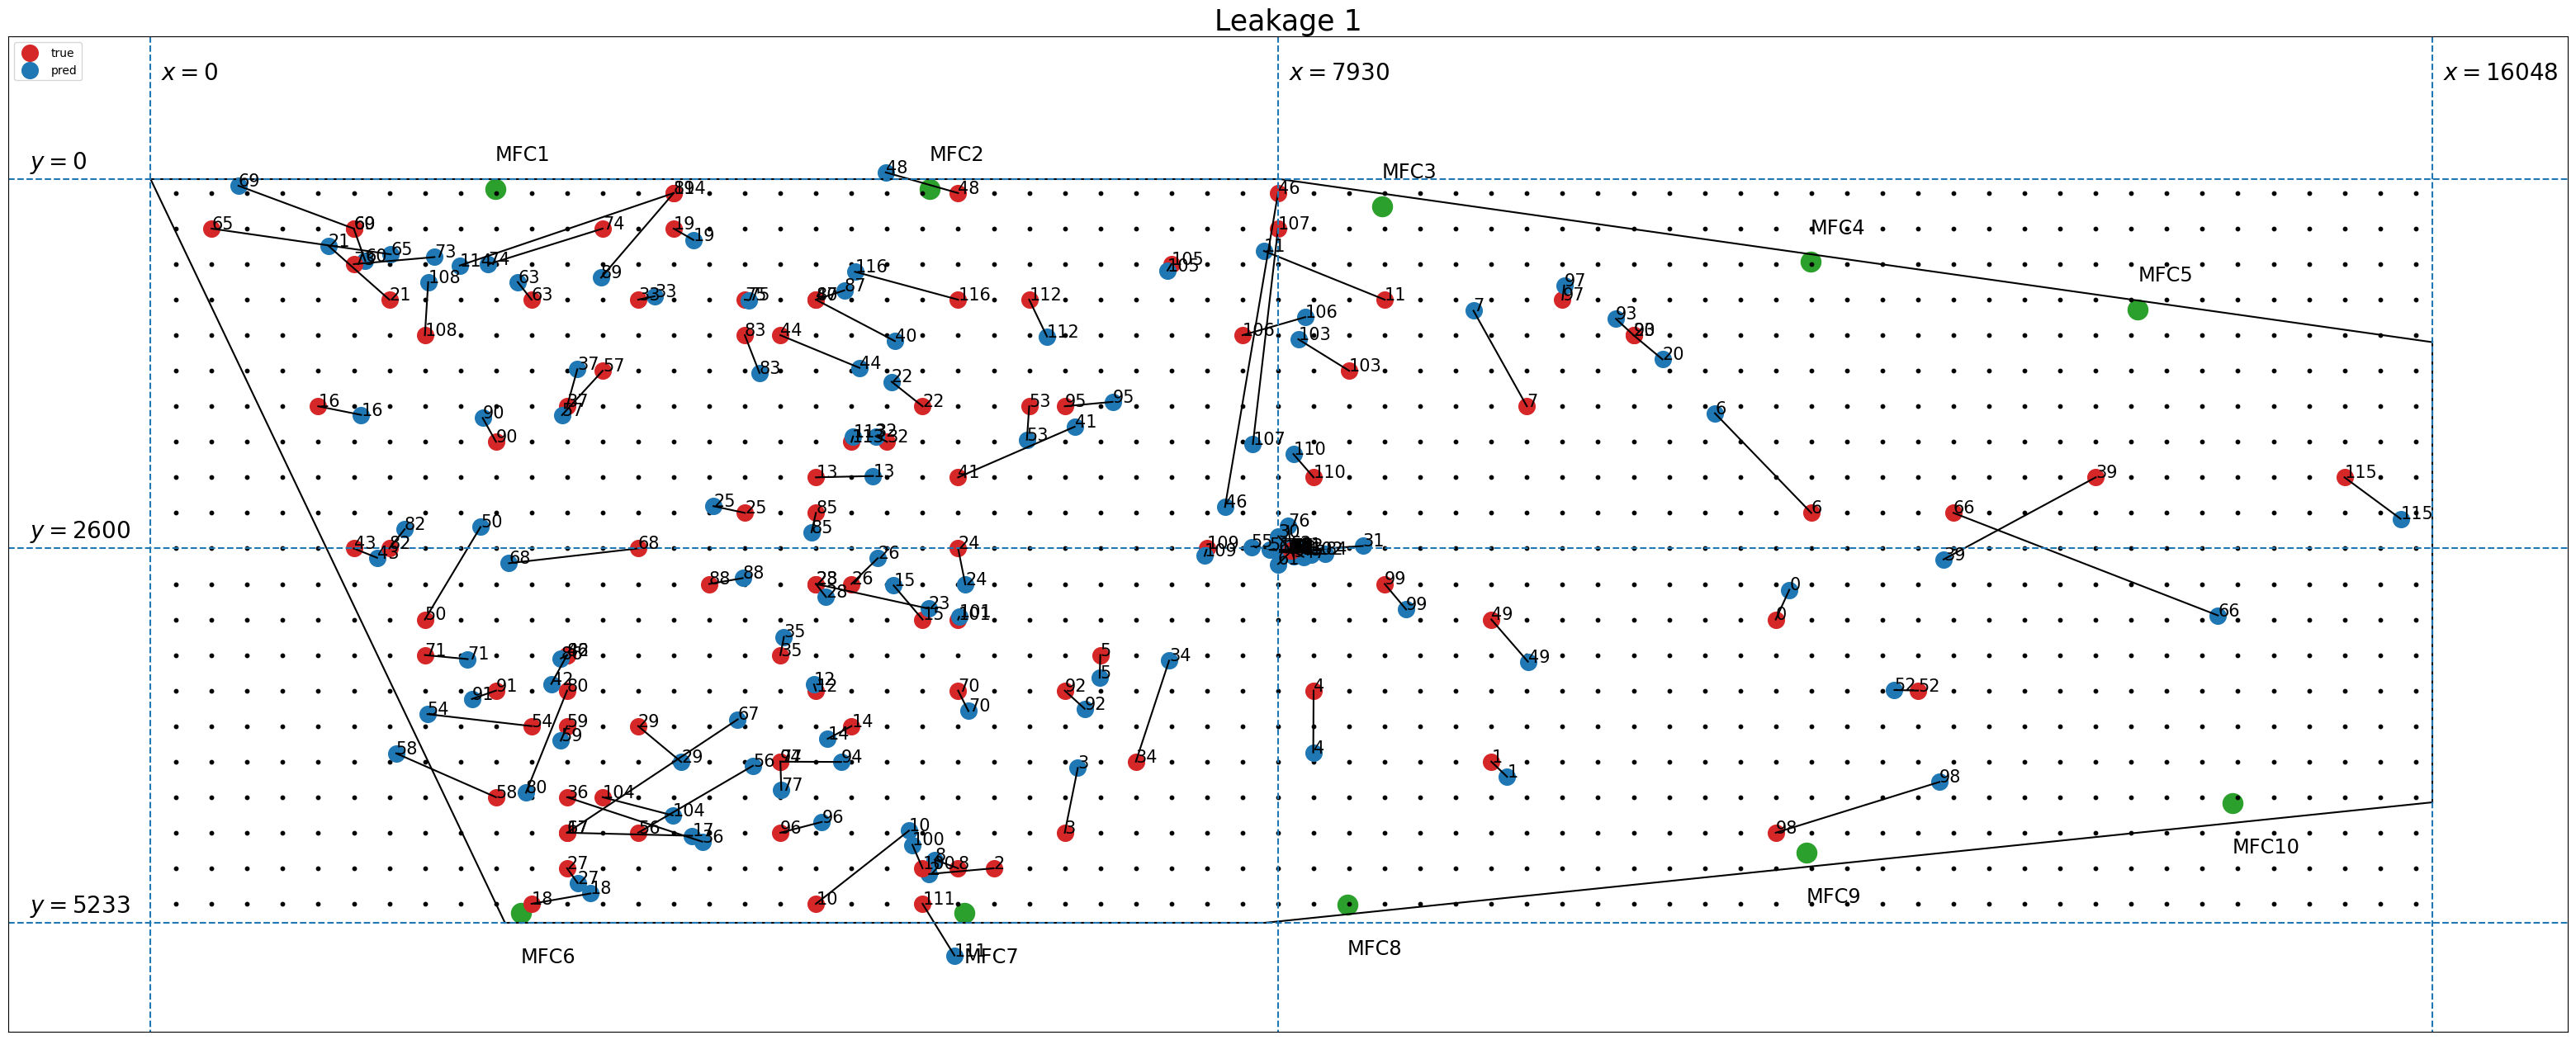

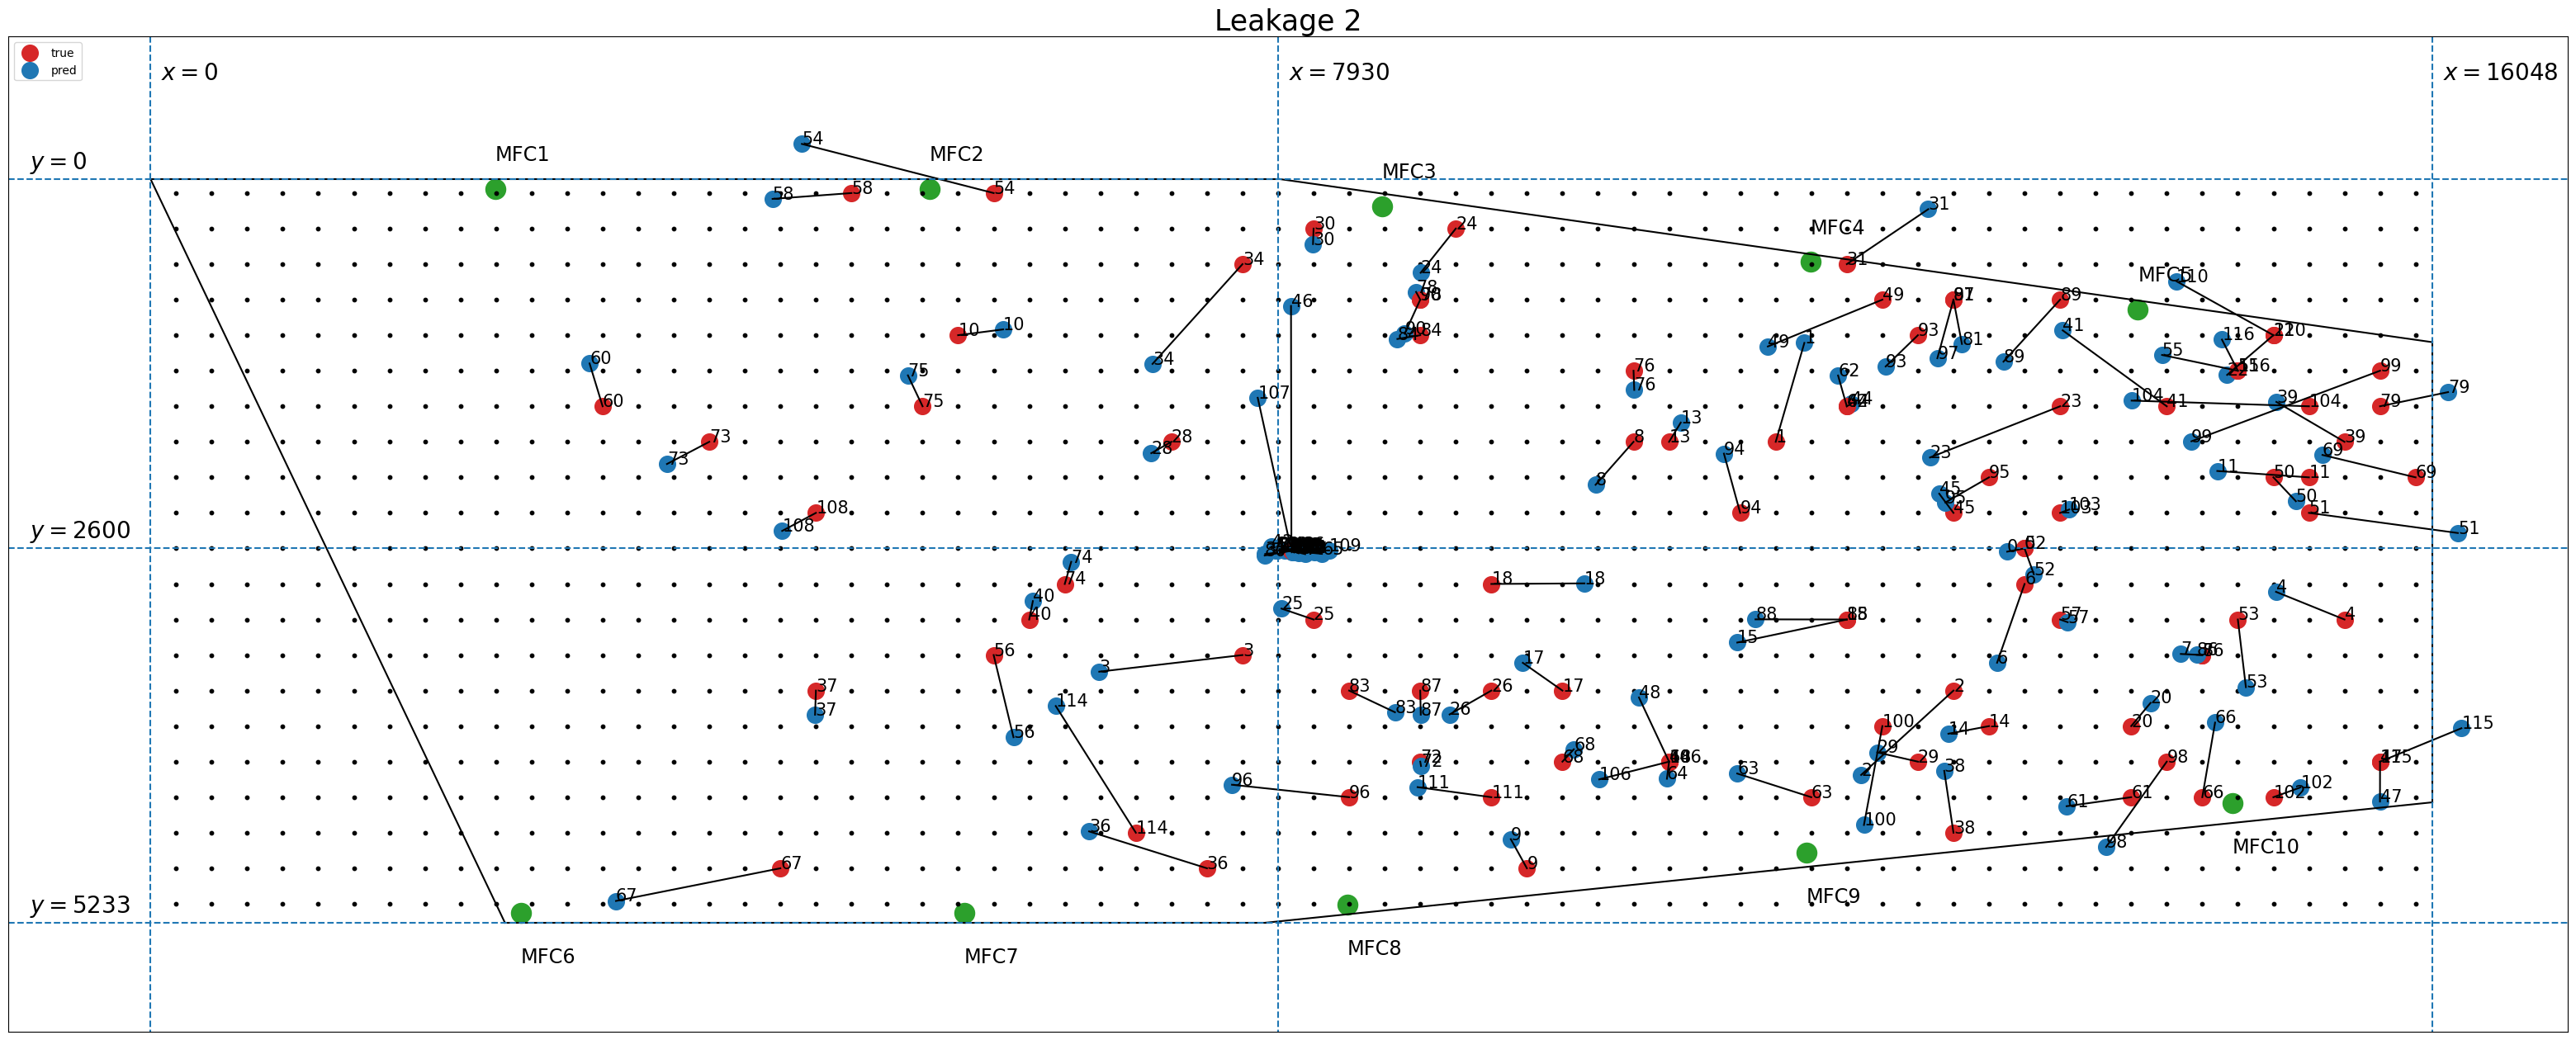

In [ ]:
x_range = np.arange(180, 16048, 250)
y_range = np.arange(100, 5233, 250)
X, Y = np.meshgrid(x_range, y_range)


def plot_test_pred(test, pred, title):
    plt.figure(figsize=(40, 20))
    
    # plt.title(f'Sample Number {sample_number}', fontsize=20)
    
    # plot sensor positions
    sensors = np.array([[2426, 70], [5480, 70], [8661, 191], [11676, 584], [13976, 917], [2603, 5163], [5723, 5163], [8417, 5103], [11646, 4740], [14641, 4391]])
    for i in range(len(sensors)):
        plt.scatter(sensors[i, 0], sensors[i, 1], color='tab:green', s=300)
        if i < 5:
            plt.text(sensors[i, 0], sensors[i, 1] - 200, 'MFC'+str(i+1), fontsize='xx-large')
        else:
            plt.text(sensors[i, 0], sensors[i, 1] + 350, 'MFC'+str(i+1), fontsize='xx-large')

    # plot leakage positions
    plt.scatter(X, Y, color='black', s=10)
    
    for i in range(len(test)):
        if i != len(test)-1:
            plt.scatter(test[i][0], test[i][1], color='tab:red', s=200)
            plt.scatter(pred[i][0], pred[i][1], color='tab:blue', s=200)
            line = np.vstack((test[i], pred[i])).transpose()
            plt.plot(line[0], line[1], color = 'black')
            plt.annotate(str(i), (pred[i][0], pred[i][1] + 0.2), fontsize=15)
            plt.annotate(str(i), (test[i][0], test[i][1] + 0.2), fontsize=15)
        else:
            plt.scatter(test[i][0], test[i][1], color='tab:red', s=200, label="true")
            plt.scatter(pred[i][0], pred[i][1], color='tab:blue', s=200, label="pred")
            line = np.vstack((test[i], pred[i])).transpose()
            plt.plot(line[0], line[1], color = 'black')
            plt.annotate(str(i), (pred[i][0], pred[i][1] + 0.2), fontsize=15)
            plt.annotate(str(i), (test[i][0], test[i][1] + 0.2), fontsize=15)

    # print(X.shape)

    # plot wing contour
    plot_wing_contour()
    plt.title(title, fontsize = 25)

    # include grid coordinate system
    plt.hlines(0, -1000, 17000, linestyle='dashed')
    plt.hlines(2600, -1000, 17000, linestyle='dashed')
    plt.hlines(5233, -1000, 17000, linestyle='dashed')
    plt.vlines(0, -1000, 6000, linestyle='dashed')
    plt.vlines(7930, -1000, 6000, linestyle='dashed')
    plt.vlines(16048, -1000, 6000, linestyle='dashed')
    plt.text(-850, -75, '$y = 0$', fontsize=20)
    plt.text(-850, 2600-75, '$y = 2600$', fontsize=20)
    plt.text(-850, 5233-75, '$y = 5233$', fontsize=20)
    plt.text(75, -700, '$x=0$', fontsize=20)
    plt.text(7930+75, -700, '$x=7930$', fontsize=20)
    plt.text(16048+75, -700, '$x=16048$', fontsize=20)
    # plt.text(180, 5800, f'(x1, y1) = ({x1}, {y1}) = ({j1-31}, {-i1+10})', fontsize=20)
    plt.legend(loc="upper left")
    # invert y axis
    plt.gca().invert_yaxis()
    # plt.savefig('./results/hypermodel_results.png')

def plot_multi_leak(test, pred):
    plot_test_pred(test[['x1', 'y1']].to_numpy(), pred[['x1', 'y1']].to_numpy(), 'Leakage 1')
    plot_test_pred(test[['x2', 'y2']].to_numpy(), pred[['x2', 'y2']].to_numpy(), 'Leakage 2')
    plt.show()

def plot_wing_contour():
    plt.plot([0, 7930], [0, 0], 'k')
    plt.plot([7930, 16048], [0, 1149], 'k')
    plt.plot([16048, 16048], [1149, 4386], 'k')
    plt.plot([16048, 7843], [4386, 5233], 'k')
    plt.plot([7843, 2493], [5233, 5233], 'k')
    plt.plot([2493, 0], [5233, 0], 'k')
    plt.xlim([-1000, 17000])
    plt.ylim([-1000, 6000])
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal')

plot_multi_leak(y1_test_unsc, predictions_unsc)